# Testing the ReGene framework

## Setup


Import libraries

In [34]:
import importlib
import regene_models
importlib.reload(regene_models)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Set the device

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

Load the Datasets

In [5]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

## Classifier

### Training

First we define the classifier

In [6]:
classifier = regene_models.Classifier(latent_dim=32, num_classes=10, device=device)

Then we train

In [7]:
classifier.train_classifier(trainloader, num_epochs=10, lr=0.001)

Epoch [1/10], Loss: 0.1032
Epoch [2/10], Loss: 0.0571
Epoch [3/10], Loss: 0.0672
Epoch [4/10], Loss: 0.0025
Epoch [5/10], Loss: 0.0200
Epoch [6/10], Loss: 0.0999
Epoch [7/10], Loss: 0.0007
Epoch [8/10], Loss: 0.2304
Epoch [9/10], Loss: 0.0065
Epoch [10/10], Loss: 0.0013


### Testing


First let's test the classifier on a few images

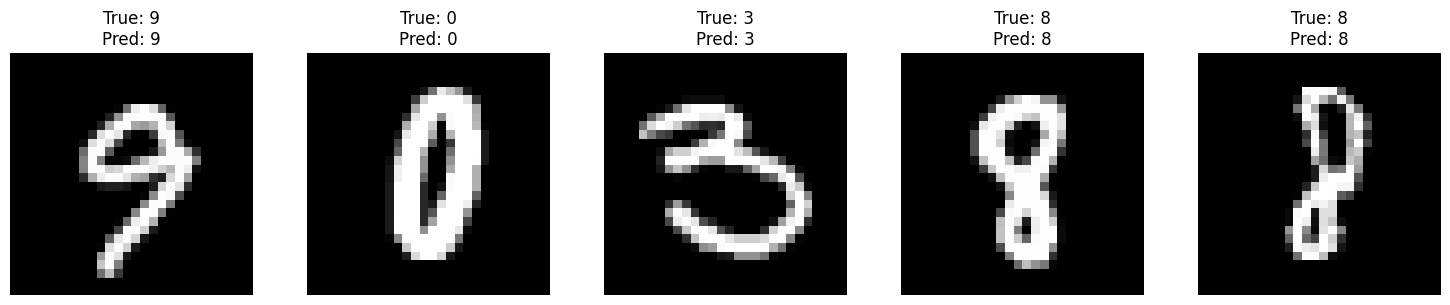

In [19]:
# Get random indices for test images
random_indices = torch.randint(0, len(trainset), (5,))
images = torch.stack([trainset[i][0] for i in random_indices])
labels = torch.tensor([trainset[i][1] for i in random_indices])

# Get predictions
classifier.eval()  # Set to evaluation mode
with torch.no_grad():
    images = images.to(device)
    _, predictions = classifier(images)
    predicted_classes = torch.argmax(predictions, dim=1)

# Plot images with true and predicted labels
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].cpu().squeeze().numpy(), cmap='gray')
    plt.title(f'True: {labels[i].item()}\nPred: {predicted_classes[i].cpu().item()}')
    plt.axis('off')

plt.tight_layout()
plt.show()


We'll also visualise the latent space. This is done by taking the latent representations of 50 training images and plotting them in 2D using t-SNE.

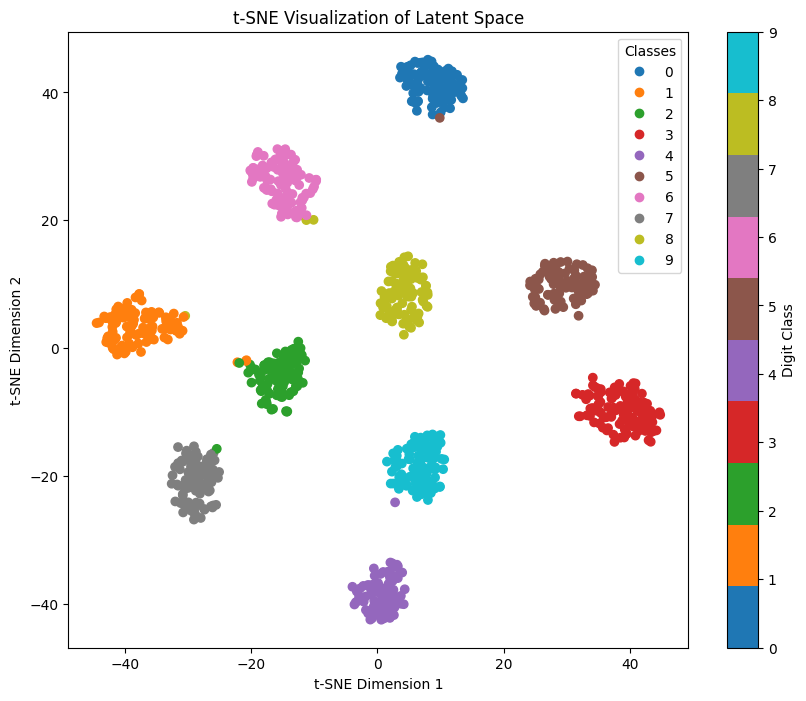

In [22]:
# Get latent representations for 50 random training images
random_indices = torch.randint(0, len(trainset), (1000,))
images = torch.stack([trainset[i][0] for i in random_indices])
labels = torch.tensor([trainset[i][1] for i in random_indices])

# Get latent representations
classifier.eval()
with torch.no_grad():
    images = images.to(device)
    latent_reps, _ = classifier(images)
    latent_reps = latent_reps.cpu().numpy()

# Perform t-SNE dimensionality reduction
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_reps)

# Plot the 2D latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10')
plt.colorbar(scatter, label='Digit Class')
plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


## Decoder

### Training

We define the decoder, and then train it using the classifier's latent space.

In [35]:
decoder = regene_models.Decoder(latent_dim=32)  

In [36]:
decoder.train_decoder(trainloader, classifier, num_epochs=5, lr=0.001)

Decoder Epoch [1/5], Loss: 0.8832
Decoder Epoch [2/5], Loss: 0.8918
Decoder Epoch [3/5], Loss: 0.8866
Decoder Epoch [4/5], Loss: 0.8758
Decoder Epoch [5/5], Loss: 0.8745


### Testing


First less visualise some reconstructions

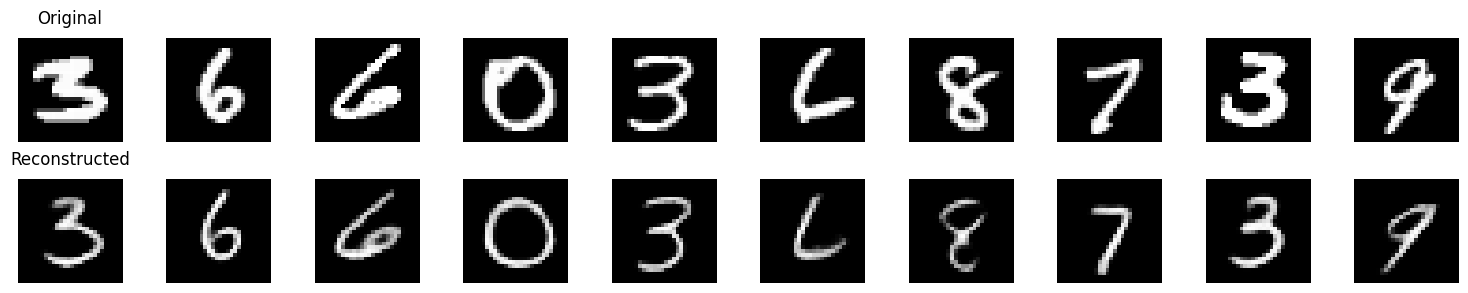

In [38]:
# Get 10 random images from training set
dataiter = iter(trainloader)
images, _ = next(dataiter)
images = images[:10]

# Get reconstructions
classifier.eval()
decoder.eval()
with torch.no_grad():
    z, _ = classifier(images)
    reconstructed = decoder(z)

# Plot original vs reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    # Original images
    axes[0,i].imshow(images[i].squeeze(), cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original', pad=10)
    
    # Reconstructed images  
    axes[1,i].imshow(reconstructed[i].squeeze(), cmap='gray')
    axes[1,i].axis('off')
    if i == 0:
        axes[1,i].set_title('Reconstructed', pad=10)

plt.tight_layout()
plt.show()
